In [1]:
import findspark
findspark.init()

import re
import pyspark.pandas as ps
import datetime
import seaborn as sns
import pyspark.sql.functions as f
#from pyspark.sql.functions import col, udf, explode, when, year, month
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, LongType, StringType, DateType, ArrayType, BooleanType

from pyspark.sql import SparkSession
import pyspark as ps
config = ps.SparkConf().setAll([
    ('spark.network.timeout', '3601s'),
    ('spark.executor.heartbeatInterval', '3600s'),
])
sc = ps.SparkContext('local[*]', '', conf=config)
spark = SparkSession(sc)

In [2]:
#!head -n 2 $PATH_METADATA_SRC
!PowerShell.exe gc "$PATH_METADATA_SRC" -head 2

Get-Content : Impossible de lier l'argument au param�tre ��Path��, car il a la valeur Null.
Au caract�re Ligne:1 : 4
+ gc $PATH_METADATA_SRC -head 2
+    ~~~~~~~~~~~~~~~~~~
    + CategoryInfo          : InvalidData : (:) [Get-Content], ParameterBindingValidationException
    + FullyQualifiedErrorId : ParameterArgumentValidationErrorNullNotAllowed,Microsoft.PowerShell.Commands.GetContentC 
   ommand
 


In [3]:
FILE_1 = "../data/metadata_sponsors_only.parquet"
schema = StructType([
    StructField("categories",    StringType(),  True),
    StructField("channel_id",    StringType(),  True),
    StructField("crawl_date",    DateType(),    True),
    StructField("description",   StringType(),  True),
    StructField("dislike_count", DoubleType(),  True), # This field must be specified as a double as it is represented as a floating point number
    StructField("display_id",    StringType(),  True),
    StructField("duration",      IntegerType(), True),
    StructField("like_count",    DoubleType(),  True), # This field must be specified as a double as it is represented as a floating point number
    StructField("tags",          StringType(),  True),
    StructField("title",         StringType(),  True),
    StructField("upload_date",   DateType(),    True),
    StructField("view_count",    DoubleType(),  True),  # This field must be specified as a double as it is represented as a floating point number
    
])

metadatas_df_1 = spark.read.parquet(FILE_1, schema=schema)

# Cast the dislike_count, like_count and view_count to their respective integer type
metadatas_df_1 = metadatas_df_1 \
    .withColumn("dislike_count", metadatas_df_1.dislike_count.cast(IntegerType())) \
    .withColumn("like_count", metadatas_df_1.like_count.cast(IntegerType())) \
    .withColumn("view_count", metadatas_df_1.view_count.cast(LongType()))

In [4]:
FILE_2 = "../data/yt_metadata_sponsor_en_domains.parquet"
metadatas_df_2 = spark.read.parquet(FILE_2)

In [6]:
print(metadatas_df_2.head)
print(metadatas_df_1.head)

<bound method DataFrame.head of DataFrame[display_id: string, domains: array<string>, domain_categories: string, is_sponsored: boolean]>
<bound method DataFrame.head of DataFrame[categories: string, channel_id: string, dislike_count: int, display_id: string, duration: int, like_count: int, tags: string, title: string, upload_date: date, view_count: bigint, domains_count: int, has_domains: string, is_sponsored: int, domains: array<string>, sponsor_category: array<string>]>


In [5]:
sponsored_videos = metadatas_df_2.filter(metadatas_df_2.is_sponsored == 1)
'''sponsored_videos.printSchema()
sponsored_videos.show()'''
sponsored_videos = sponsored_videos.withColumn("domain_categories",  f.regexp_replace(f.regexp_replace("domain_categories", "\\[", ""), "\\]", ""))
sponsored_videos = sponsored_videos.withColumn('dom_categories', f.regexp_replace(f.col("domain_categories"), " ", "")).drop('domain_categories')
#spaceDeleteUDF = f.udf(lambda s: s.replace(" ", ""), StringType())
#sponsored_videos = sponsored_videos.withColumn("domain_categories", spaceDeleteUDF("domain_categories"))


In [6]:
sponsored_videos = sponsored_videos.withColumn('arr_categories' ,f.split(f.col("dom_categories"),",")) \
    .drop("domain_categories")
sponsored_videos.head

<bound method DataFrame.head of DataFrame[display_id: string, domains: array<string>, is_sponsored: boolean, dom_categories: string, arr_categories: array<string>]>

In [93]:
#sponsored_videos = sponsored_videos.withColumn('domain_categories', f.explode('arr_categories')).drop('arr_categories')

+-----------+--------------------+------------+-----------------+
| display_id|             domains|is_sponsored|domain_categories|
+-----------+--------------------+------------+-----------------+
|--2vlpMag3o|[store.payloadz.c...|        true|      Application|
|--2vlpMag3o|[store.payloadz.c...|        true|          Service|
|--8naaS32Do|[g2a.com, gta4-mo...|        true|        VideoGame|
|--9YGgXAGZY|[gematsu.com, gon...|        true|      Application|
|--AV-5N5pI8|          [etsy.com]|        true|          Fashion|
|--CdRsiR9b4|[arsenalfantv.com...|        true|           Agency|
|--LRd59WG6U|[binance.com, coi...|        true|           Crypto|
|--L_DTb4pVU|     [teespring.com]|        true|           Agency|
|--Lb_Wn0ouk|[gofundme.com, wh...|        true|      Application|
|--Oh7lcjIBo|[itunes.apple.com...|        true|      Application|
|--T4O8SG6gk|[play.google.com,...|        true|      Application|
|--UJ-Ie16qE|[nyoooz.com, play...|        true|      Application|
|--UWZWOR2

---------------------------------------

Brouillon

In [103]:
tt = sponsored_videos.withColumn('domain_categories', f.explode('arr_categories')).drop('arr_categories')
tt_count = tt.groupby('domain_categories').count()
df_tt = tt_count.toPandas()
df_tt

,domain_categories,count
0,Application,2624227
1,Education,145744
2,Entertainment,17115
3,Fashion,361688
4,Crypto,47091
5,Photo,10175
6,Travel,30961
7,Finance,21619
8,Religion,4798
9,Media,30168


In [104]:
import numpy as np
np.unique(df_tt.domain_categories)

array(['Agency', 'Application', 'Beauty', 'Book', 'Crypto', 'Education',
       'Entertainment', 'Fashion', 'Finance', 'FoodDrink', 'Media',
       'Medical', 'Music', 'Photo', 'RealEstate', 'Religion', 'Service',
       'Shop', 'Shorten', 'SocialMedia', 'Sport', 'Streaming',
       'Technology', 'Travel', 'Vehicle', 'VideoGame', 'YCW'],
      dtype=object)

Fin Brouillon

------------------------------------------------------

In [7]:
metadatas_df1 = metadatas_df_1.drop('is_domain', 'is_sponsored', 'domains','sponsor_category',"description")
fusion_df = metadatas_df1.join(sponsored_videos,
                    metadatas_df1.display_id == sponsored_videos.display_id,
                    'inner'
                    )

In [64]:
fusion_df.head

<bound method DataFrame.head of DataFrame[categories: string, channel_id: string, dislike_count: int, display_id: string, duration: int, like_count: int, tags: string, title: string, upload_date: date, view_count: bigint, domains_count: int, has_domains: string, display_id: string, domains: array<string>, is_sponsored: boolean, arr_categories: array<string>]>

In [8]:
def diff_month(d1,d2):
    
    return (d1.year - d2.year) * 12 + d1.month - d2.month


udf_mois = f.udf(diff_month, IntegerType())
row1 = fusion_df.agg({"upload_date": "min"}).collect()[0]
min_date = row1['min(upload_date)']


In [9]:

monthUDF = f.udf(lambda x:diff_month(x,min_date) , IntegerType())
fusion_df = fusion_df.withColumn('month_cnt', monthUDF(fusion_df.upload_date))

In [67]:
fusion_df.head

<bound method DataFrame.head of DataFrame[categories: string, channel_id: string, dislike_count: int, display_id: string, duration: int, like_count: int, tags: string, title: string, upload_date: date, view_count: bigint, domains_count: int, has_domains: string, display_id: string, domains: array<string>, is_sponsored: boolean, arr_categories: array<string>, month_cnt: int]>

Explode by domain_categories

In [10]:
explode_cat = fusion_df.withColumn("domain_categories", f.explode("arr_categories")).drop('arr_categories')
explode_cat.head


<bound method DataFrame.head of DataFrame[categories: string, channel_id: string, dislike_count: int, display_id: string, duration: int, like_count: int, tags: string, title: string, upload_date: date, view_count: bigint, domains_count: int, has_domains: string, display_id: string, domains: array<string>, is_sponsored: boolean, dom_categories: string, month_cnt: int, domain_categories: string]>

In [11]:
count_month_cat = explode_cat.groupby('month_cnt','domain_categories').count()

convert domain count pyspark to Pandas

In [13]:
df_count_month_cat = count_month_cat.toPandas()

In [17]:
import numpy as np
categories_arr = np.unique(df_count_month_cat.domain_categories)

In [18]:
df_count_month_cat.set_index("month_cnt", inplace = True)

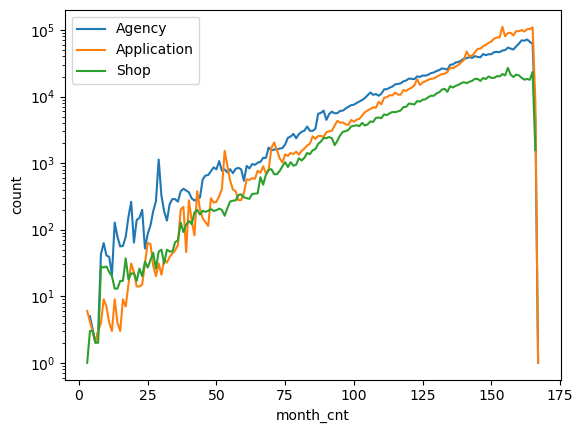

In [22]:
import matplotlib.pyplot as plt
groups = df_count_month_cat.groupby('domain_categories')
fig, axs = plt.subplots()
#ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
i = 0
test_list = ['Agency', 'Application', 'Shop']
for name, group in groups:
    if name in test_list:

        sns.lineplot(x="month_cnt", y="count", data=group, label = name)
    

    #ax.plot(group.month_cnt, group.count, marker='o', linestyle='', ms=12, label=name)
plt.yscale('log')
plt.show()

Bootstrap for each categories domain

In [28]:
from tqdm import tqdm
def bootstrap(df, column, n_bootstrap=1000, alpha=0.05):
    # Get distribution values
    values = df.select(column).rdd.flatMap(lambda x: x).collect()
    values_list = []
    values = [x for x in values if x is not None]
    n_samples = len(values)
    for i in tqdm(range(n_bootstrap)):
        values_list.append(np.mean(np.random.choice(values, n_samples, replace=True)))

    # GET CI
    values_list.sort()
    lower = int(n_bootstrap * alpha / 2)
    upper = int(n_bootstrap * (1 - alpha / 2))
    return values_list, values_list[lower], values_list[upper]

In [55]:
n_bootstrap = 1000
dict_category_bootstrap = {}
for category in categories_arr:
    category_df = explode_cat.filter(explode_cat.domain_categories == category)
    bootstrap_cat, ci_cat_lower, ci_cat_upper = bootstrap(category_df, 'month_cnt', n_bootstrap=n_bootstrap)
    category_dict = {
        category: {
        'values': bootstrap_cat,
        'ci_lower': ci_cat_lower,
        'ci_upper': ci_cat_upper
        }
    }
    dict_category_bootstrap.update(category_dict)

    

100%|██████████| 1000/1000 [00:00<00:00, 2042.92it/s]


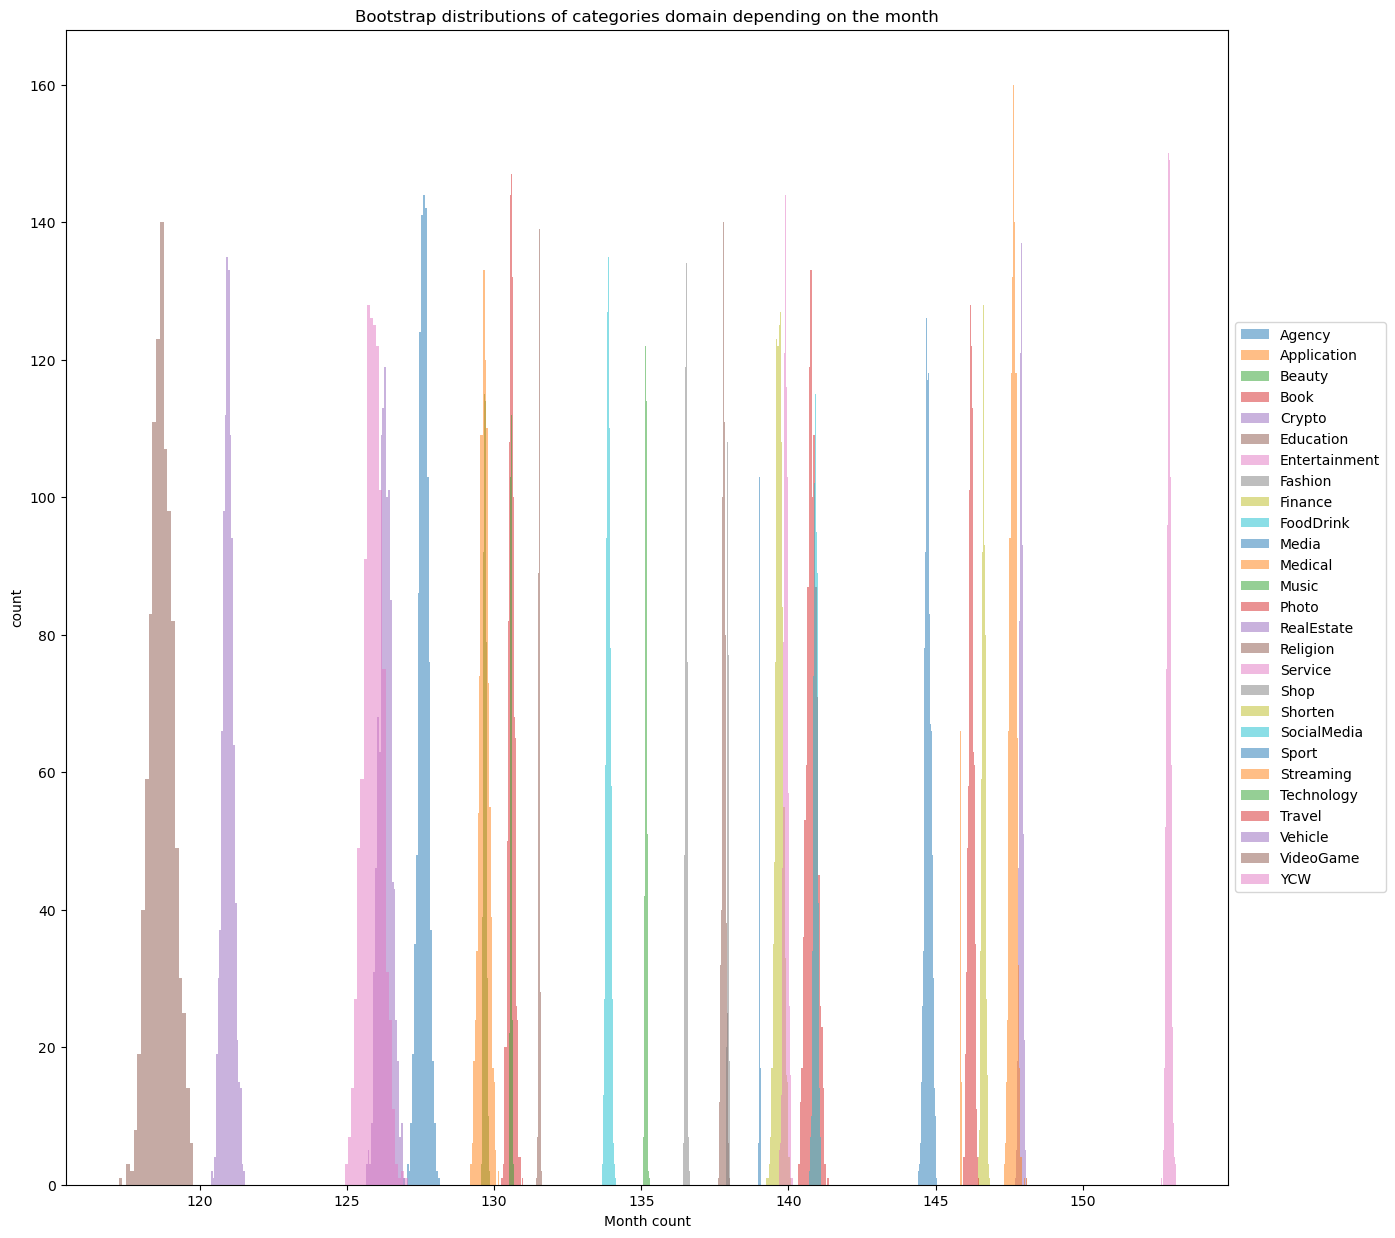

In [93]:
# plot histograms
fig, ax = plt.subplots(figsize=(15, 15))
for i, category in enumerate(dict_category_bootstrap):
    ax.hist(dict_category_bootstrap[category]['values'], bins=20, alpha=0.5, label=category)

ax.set_title('Bootstrap distributions of categories domain depending on the month')
plt.xlabel("Month count")
plt.ylabel("count")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

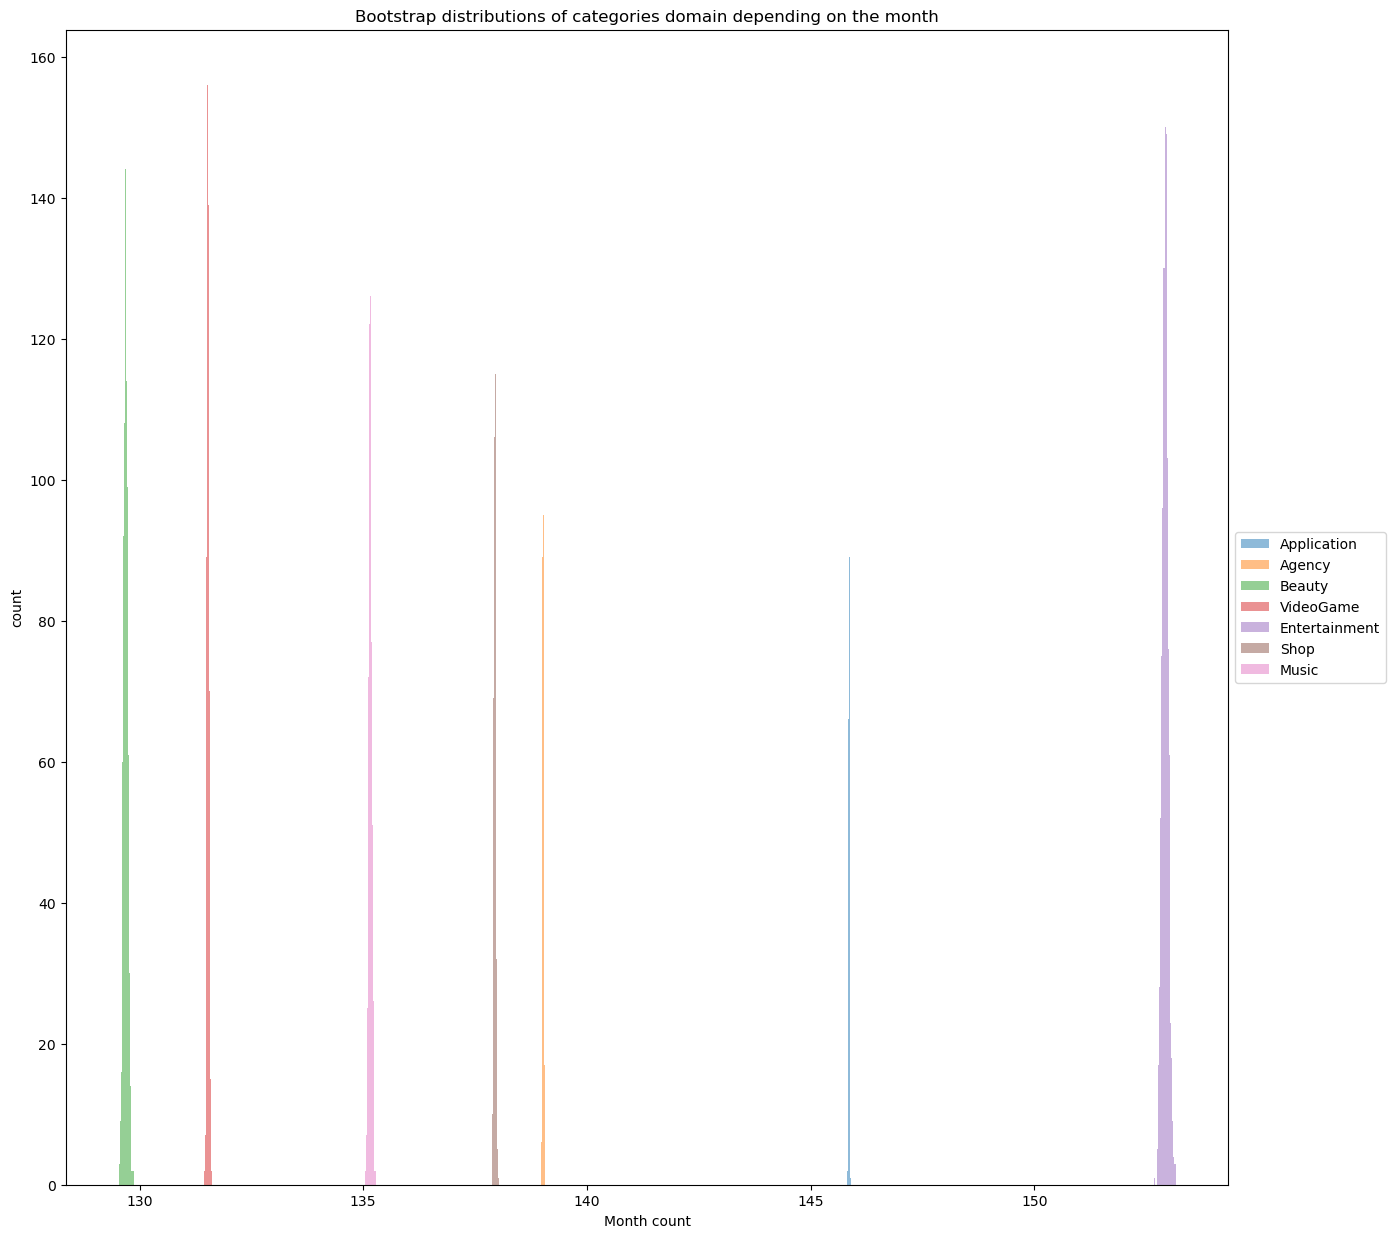

In [92]:
category_list_1 = ['Application', 'Agency', 'Beauty', 'VideoGame','Entertainment','Shop', 'Music']
# plot histograms
fig, ax = plt.subplots(figsize=(15, 15))
for category in category_list_1:
    ax.hist(dict_category_bootstrap[category]['values'], bins=20, alpha=0.5, label=category)
    #ax.axvline(dict_category_bootstrap[category]['ci_lower'], color='red', linestyle='dashed', linewidth=1)
    #ax.axvline(dict_category_bootstrap[category]['ci_upper'], color='red', linestyle='dashed', linewidth=1)
ax.set_title('Bootstrap distributions of categories domain depending on the month')
plt.xlabel("Month count")
plt.ylabel("count")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

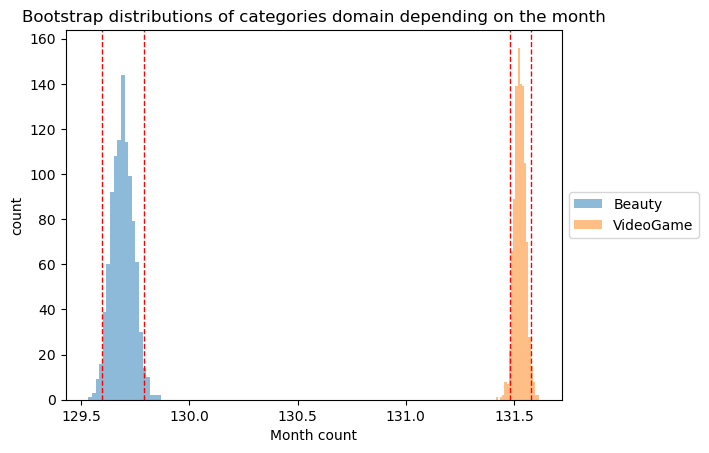

In [94]:
category_list_videogame_beauty = ['Beauty', 'VideoGame']
# plot histograms
fig, ax = plt.subplots()
for category in category_list_videogame_beauty:
    ax.hist(dict_category_bootstrap[category]['values'], bins=20, alpha=0.5, label=category)
    ax.axvline(dict_category_bootstrap[category]['ci_lower'], color='red', linestyle='dashed', linewidth=1)
    ax.axvline(dict_category_bootstrap[category]['ci_upper'], color='red', linestyle='dashed', linewidth=1)
    
ax.set_title('Bootstrap distributions of categories domain depending on the month')
plt.xlabel("Month count")
plt.ylabel("count")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Text(0, 0.5, 'count')

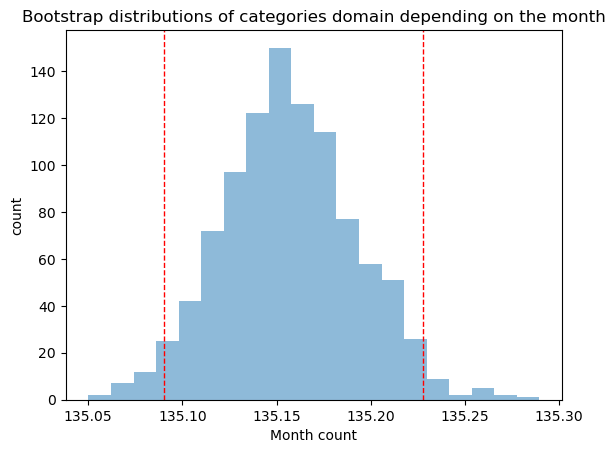

In [95]:
fig, ax = plt.subplots()
ax.hist(dict_category_bootstrap['Music']['values'], bins=20, alpha=0.5, label=category)
ax.axvline(dict_category_bootstrap['Music']['ci_lower'], color='red', linestyle='dashed', linewidth=1)
ax.axvline(dict_category_bootstrap['Music']['ci_upper'], color='red', linestyle='dashed', linewidth=1)

ax.set_title('Bootstrap distributions of categories domain depending on the month')
plt.xlabel("Month count")
plt.ylabel("count")

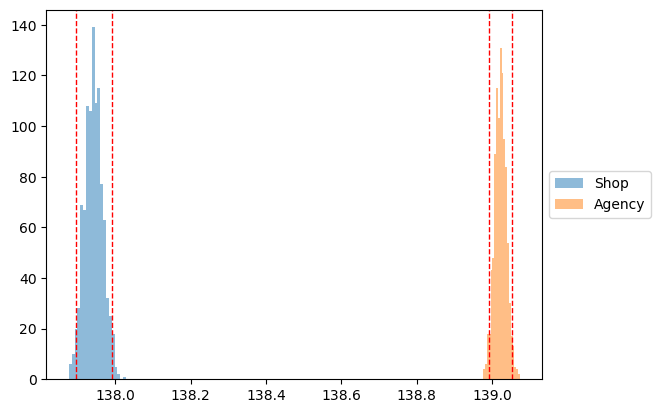

In [84]:
category_list_shop_agency = ['Shop', 'Agency']
fig, ax = plt.subplots()
for category in category_list_shop_agency:
    ax.hist(dict_category_bootstrap[category]['values'], bins=20, alpha=0.5, label=category)
    ax.axvline(dict_category_bootstrap[category]['ci_lower'], color='red', linestyle='dashed', linewidth=1)
    ax.axvline(dict_category_bootstrap[category]['ci_upper'], color='red', linestyle='dashed', linewidth=1)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Explode by domains and filter app.google, rstyle.me and unionforgamers.com

In [96]:
explode_domain = fusion_df.withColumn("domain", f.explode("domains")).drop('domains')
keep_google = explode_domain.filter(explode_domain.domain == 'play.google.com')
count_month_google = keep_google.groupby('month_cnt').count()

In [97]:
keep_rstyle = explode_domain.filter(explode_domain.domain == 'rstyle.me')
count_month_rstyle = keep_rstyle.groupby('month_cnt').count()

In [98]:
keep_union_gamer = explode_domain.filter(explode_domain.domain == 'unionforgamers.com')
count_month_union_gamer = keep_union_gamer.groupby('month_cnt').count()

--> convert google videos pyspark into pandas

In [99]:
df_google = count_month_google.toPandas()
df_google

,month_cnt,count
0,148,44601
1,31,17
2,137,27986
3,85,1712
4,65,585
...,...,...
157,12,3
158,16,3
159,15,3
160,14,2


In [17]:
df_rstyle = count_month_rstyle.toPandas()
df_rstyle

,month_cnt,count
0,148,29839
1,137,20072
2,85,286
3,133,16717
4,78,140
...,...,...
116,67,14
117,46,6
118,54,1
119,39,3


In [20]:
df_union = count_month_union_gamer.toPandas()
df_union

,month_cnt,count
0,148,2544
1,137,3730
2,85,19
3,133,3256
4,78,57
...,...,...
104,65,1
105,73,9
106,55,1
107,60,2


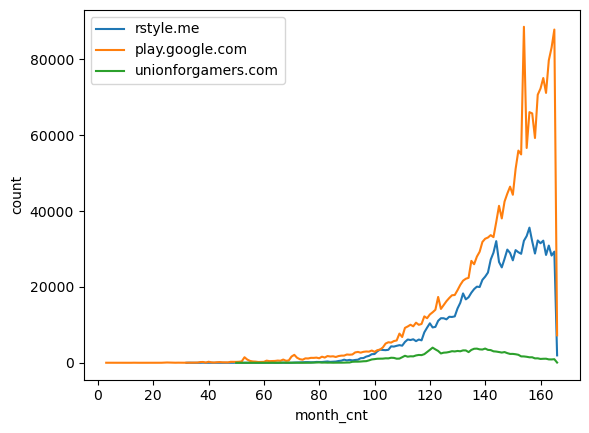

<Figure size 1500x1500 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt
sns.lineplot(x="month_cnt", y="count", data=df_rstyle, label = 'rstyle.me')
sns.lineplot(x="month_cnt", y="count", data=df_google, label = 'play.google.com')
sns.lineplot(x="month_cnt", y="count", data=df_union, label = 'unionforgamers.com')
plt.figure(figsize=(15,15))
plt.yscale('log')
plt.show()